In [1]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [3]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph-Structures")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph-Structures]


## 기본 그래프를 생성하는 방법

LangGraph 의 그래프를 정의하기 위해서는

1. State 정의
2. 노드 정의
3. 그래프 정의
4. 그래프 컴파일
5. 그래프 시각화

단계를 거칩니다.  
  
**목표**
- 그래프 생성시 조건부 엣지를 사용하는 방법을 익힙니다.
- 그래프의 다양한 흐름 변경 방법을 익힙니다.

### 1. State 정의

In [4]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langchain_core.documents import Document
import operator


class State(TypedDict):
    context: Annotated[List[Document], operator.add]  # 내용이 계속 추가됨
    answer: Annotated[List[Document], operator.add]
    question: Annotated[str, "user question"]
    sql_query: Annotated[str, "sql query"]
    binary_socre: Annotated[str, "binary sore yes or no"]

### 2. 노드 정의

In [9]:
# retrieve: 검색
def retrieve(state: State) -> State:
    document = "검색된 문서"
    return {"context": document}


# rewrite_query: 쿼리 재작성
def rewrite_query(state: State) -> State:
    document = "검색된 문서"
    return State(context=document)


# llm_gpt_execute: LLM 실행
def llm_gpt_execute(state: State) -> State:
    answer = "검색된 문서"
    return State(answer=answer)


# llm_gemini_execute: gemini 실행
def llm_gemini_execute(state: State) -> State:
    answer = "gemini 의 생성된 답변"
    return State(answer=answer)


# relevance_check: 관련성 확인
def relevance_check(state: State) -> State:
    return State(binary_score="binary score")


# sum_up: 결과 종합
def sum_up(state: State) -> State:
    answer = "종합된 답변"
    return State(answer=answer)


# search_on_web: 웹 검색
def search_on_web(state: State) -> State:
    document = state["context"] = "기존 문서"
    searched_documents = "검색된 문서"
    documents += searched_documents
    return State(context=documents)


# get_table_info: 테이블 정보 가져오기
def get_table_info(state: State) -> State:
    table_info = "테이블 정보"
    return State(table_info=table_info)


# generate_sql_query: sql 쿼리 생성
def generate_sql_query(state: State) -> State:
    sql_query = "sql 쿼리"
    return State(sql_query=sql_query)


# execute_sql_query: sql 쿼리 실행
def execute_sql_query(state: State) -> State:
    sql_result = "sql 결과"
    return State(sql_result=sql_result)


# validate_sql_query: sql 쿼리 검증
def validate_sql_query(state: State) -> State:
    binary_score = "SQL 쿼리 검증 결과"
    return State(binary_score=binary_score)


# handle_error: 에러 처리
def handle_error(state: State) -> State:
    error = "에러 발생"
    return State(context=error)


# decision: 의사 결정
def decision(state: State) -> State:
    decision = "결정"

    if state["binary_score"] == "yes":
        return "종료"
    else:
        return "재검색"

### 3. 그래프 정의

#### 1. Conventional RAG

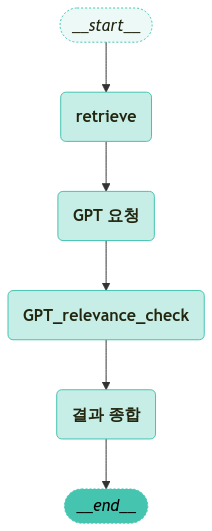

In [12]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from graphs import visualize_graph

workflow = StateGraph(State)

# 노드 추가
workflow.add_node("retrieve", retrieve)
workflow.add_node("GPT 요청", llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)

# 엣지 설정
workflow.add_edge("retrieve", "GPT 요청")
workflow.add_edge("GPT 요청", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "결과 종합")
workflow.add_edge("결과 종합", END)

# 시작점 설정
workflow.set_entry_point("retrieve")

# 메모리 설정
memory = MemorySaver()

# 그래프 컴파일
app = workflow.compile(checkpointer=memory)

# 그래프 시각화
visualize_graph(app)

#### 2. 재검색

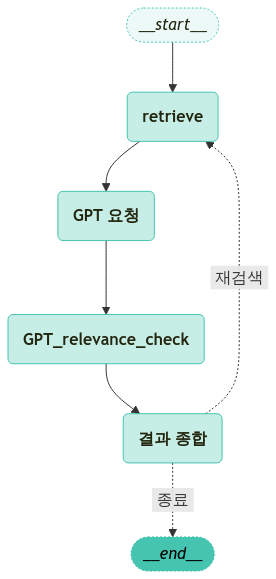

In [13]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from graphs import visualize_graph

workflow = StateGraph(State)

# 노드 추가
workflow.add_node("retrieve", retrieve)
workflow.add_node("GPT 요청", llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)

# 엣지 설정
workflow.add_edge("retrieve", "GPT 요청")
workflow.add_edge("GPT 요청", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "결과 종합")

# 조건부 엣지
workflow.add_conditional_edges(
    "결과 종합",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    decision,
    {
        "재검색": "retrieve",  # 관련성이 있으면 종료합니다.
        "종료": END,  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
    },
)

# 시작점 설정
workflow.set_entry_point("retrieve")

# 메모리 설정
memory = MemorySaver()

# 그래프 컴파일
app = workflow.compile(checkpointer=memory)

# 그래프 시각화
visualize_graph(app)

#### 3. 멀티 LLM

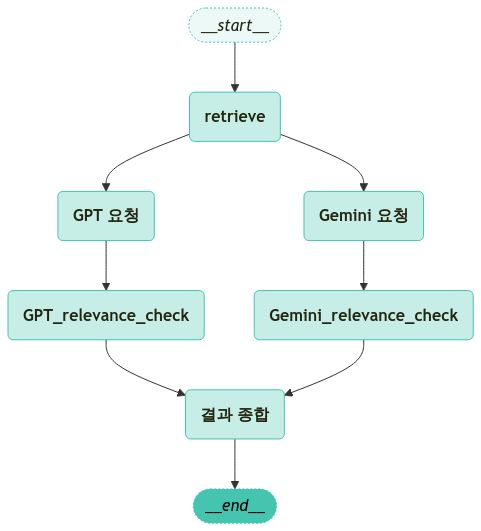

In [14]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from graphs import visualize_graph

workflow = StateGraph(State)

# 노드 추가
workflow.add_node("retrieve", retrieve)
workflow.add_node("GPT 요청", llm_gpt_execute)
workflow.add_node("Gemini 요청", llm_gemini_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("Gemini_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)

# 각 노드들을 연결합니다.
workflow.add_edge("retrieve", "GPT 요청")
workflow.add_edge("retrieve", "Gemini 요청")
workflow.add_edge("GPT 요청", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "결과 종합")
workflow.add_edge("Gemini 요청", "Gemini_relevance_check")
workflow.add_edge("Gemini_relevance_check", "결과 종합")

workflow.add_edge("결과 종합", END)

# 시작점 설정
workflow.set_entry_point("retrieve")

# 메모리 설정
memory = MemorySaver()

# 그래프 컴파일
app = workflow.compile(checkpointer=memory)

# 그래프 시각화
visualize_graph(app)

#### 4. 쿼리 재작성

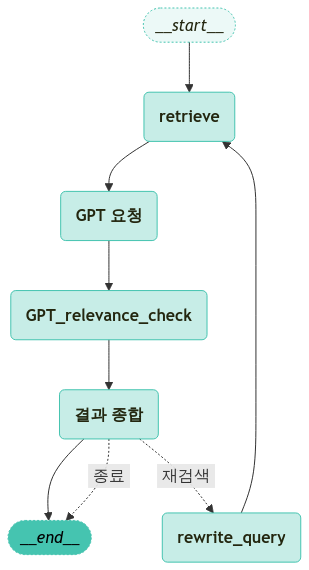

In [18]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from graphs import visualize_graph

workflow = StateGraph(State)

# 노드 추가
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("GPT 요청", llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)

# 엣지 설정
workflow.add_edge("retrieve", "GPT 요청")
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("GPT 요청", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "결과 종합")

workflow.add_edge("결과 종합", END)

# 조건부 엣지를 추가합니다. (2), (4)
# workflow.add_conditional_edges(
#     "결과 종합",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
#     decision,
#     {
#         "재검색": "retrieve",  # 관련성이 있으면 종료합니다.
#         "종료": END,  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
#     },
# )

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "결과 종합",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    decision,
    {
        "재검색": "rewrite_query",  # 관련성이 있으면 종료합니다.
        "종료": END,  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
    },
)

# 시작점 설정
workflow.set_entry_point("retrieve")

# 메모리 설정
memory = MemorySaver()

# 그래프 컴파일
app = workflow.compile(checkpointer=memory)

# 그래프 시각화
visualize_graph(app)

In [10]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# langgraph.graph에서 StateGraph와 END를 가져옵니다.
workflow = StateGraph(State)

# 노드를 추가합니다.
workflow.add_node("질문", retrieve)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("rewrite_question", rewrite_query)
workflow.add_node("GPT 요청", llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)
workflow.add_node("get_table_info", get_table_info)
workflow.add_node("generate_sql_query", generate_sql_query)
workflow.add_node("execute_sql_query", execute_sql_query)
workflow.add_node("validate_sql_query", validate_sql_query)

# 각 노드들을 연결합니다.
workflow.add_edge("질문", "get_table_info")
workflow.add_edge("get_table_info", "generate_sql_query")
workflow.add_edge("generate_sql_query", "execute_sql_query")
workflow.add_edge("execute_sql_query", "validate_sql_query")

workflow.add_conditional_edges(
    "validate_sql_query",
    decision,
    {
        "QUERY ERROR": "rewrite_query",
        "UNKNOWN MEANING": "rewrite_question",
        "PASS": "GPT 요청",
    },
)

workflow.add_edge("rewrite_query", "execute_sql_query")
workflow.add_edge("rewrite_question", "rewrite_query")
workflow.add_edge("GPT 요청", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "결과 종합")
workflow.add_edge("결과 종합", END)

# 시작점을 설정합니다.
workflow.set_entry_point("질문")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
app = workflow.compile(checkpointer=memory)

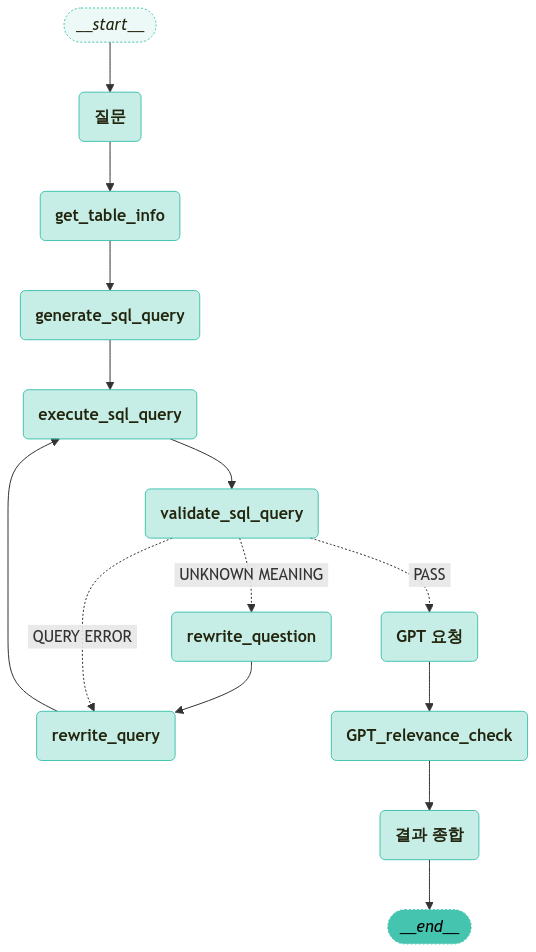

In [11]:
from graphs import visualize_graph

visualize_graph(app)